# Statistical Modeling of Diffuse Solar Irradiance from Direct Irradience and Cloud Cover measurements

In [1]:
#IMPORTS
import pandas as pd
import os
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import pylab as py

print(os.listdir())

['data_munger.py', 'Testing_Data', '.DS_Store', '.irradience_fitter.ipynb.icloud', '.Data_Viz 2.ipynb.icloud', 'playing_with_pvlib.ipynb', 'statistical_modeling.py', '.statisical_irradience_modeling.ipynb.icloud', 'Raw_Data', 'README.md', 'psm_VA_Charlottesville2018cloud_output.csv', '.ipynb_checkpoints', '.git']


In [2]:
#Time for Polynomial Fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, median_absolute_error


In [3]:
_Curr_Dir = os.getcwd()
_Testing_Data_Dir = os.path.join(_Curr_Dir, 'Testing_Data')


In [4]:
def logify_df(df):
    df['DHI_log'] = np.log(df['DHI'])
    df['GHI_log'] = np.log(df['GHI'])
    return df

In [5]:
def make_df_nonzero(df):
    df_no_zero = df.loc[df['DHI']!= 0 ]
    assert len(df_no_zero['DHI'])==len(df_no_zero['GHI']), "Some DHI 0s where GHI is not 0"
    print(df_no_zero)
    return df_no_zero 

In [6]:
def meta_visualization(data, x='GHI', y='DHI', z='Cloud Cover'):
    sns.lmplot(x, y, data=data, hue=z, fit_reg=False)
    plt.show()
    return

In [7]:
def segment_visualization(data, x='GHI', y='DHI', z='Cloud Cover'):
    sns.lmplot(x, y, data=data, hue=z, row=z, fit_reg=True)
    plt.show()
    return

In [8]:
def make_OLS(X, Y):
    ols_model = LinearRegression().fit(X, Y)
    r2 = ols_model.score(X, Y)
    print("r2 is ", r2)
    return ols_model, r2

In [9]:
def show_model_metrics(X, Y, model):
    preds = model.predict(X)
    resids = Y - preds
    rmse = np.sqrt(mean_squared_error(Y,preds))
    r2 = r2_score(Y,preds)
    print("rmse is ", rmse)
    print("r2 is ",r2)
    print("mean absolute error is ",mean_absolute_error(Y,preds))
    print("mean squared log error is ", mean_squared_log_error(Y, preds))
    print("median absolute error is ", median_absolute_error(Y, preds))
    print("MAPE is ", np.mean(np.abs((Y - preds) / Y)) * 100)
    return preds, resids

## South Dakota 2018 Data, aka the original data 

In [10]:
#Get 2018 Data
df1_2018 = pd.read_csv(os.path.join(_Testing_Data_Dir, 'psm_testing_data2018.csv'))

In [11]:
print(df1_2018)

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
0     2018      1    1     0      30        -22.5             0             0   
1     2018      1    1     1      30        -23.1             0             0   
2     2018      1    1     2      30        -23.6             0             0   
3     2018      1    1     3      30        -23.9             0             0   
4     2018      1    1     4      30        -24.1             0             0   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   
8759  2018     12   31    23      30        -15.1             0             0   

      Clearsky GHI  Cloud T

In [12]:
#Zeros are removed because it ends up recording hours of night time data
#We dont need to record when sunlight is 0
logify_df(df1_2018)
df1_2018 = make_df_nonzero(df1_2018)

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
8754  2018     12   31    18      30        -12.9            65           889   
8755  2018     12   31    19      30        -12.8            60           892   
8756  2018     12   31    20      30        -13.0            52           859   
8757  2018     12   31    21      30        -13.6            41           770   
8758  2018     12   31    22      30        -14.6            26           537   

      Clearsky GHI  Cloud T

/usr/local/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


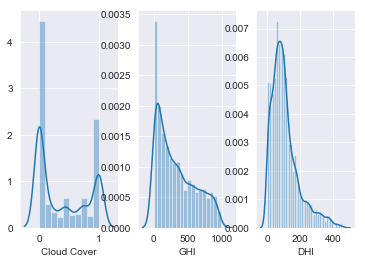

In [13]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=3)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(df1_2018['GHI'], ax=axs[1])
sns.distplot(df1_2018['DHI'], ax=axs[2])

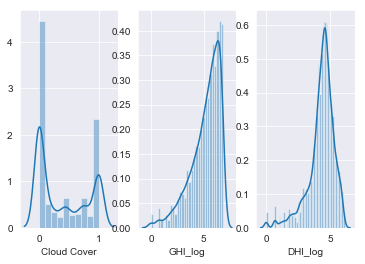

In [14]:
#Take a look at data distribution in logs
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=3)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(df1_2018['GHI_log'], ax=axs[1])
sns.distplot(df1_2018['DHI_log'], ax=axs[2])

In [15]:
"""
Assumptions of Linear Regression:

1.Linearity: The relationship between X and the mean of Y is linear.
    -IE tthe residuals should be normally distributed
2.Homoscedasticity: The variance of residual is the same for any value of X.
3.Independence: Observations are independent of each other.
4.Normality: For any fixed value of X, Y is normally distributed.

""" 

'\nAssumptions of Linear Regression:\n\n1.Linearity: The relationship between X and the mean of Y is linear.\n    -IE tthe residuals should be normally distributed\n2.Homoscedasticity: The variance of residual is the same for any value of X.\n3.Independence: Observations are independent of each other.\n4.Normality: For any fixed value of X, Y is normally distributed.\n\n'

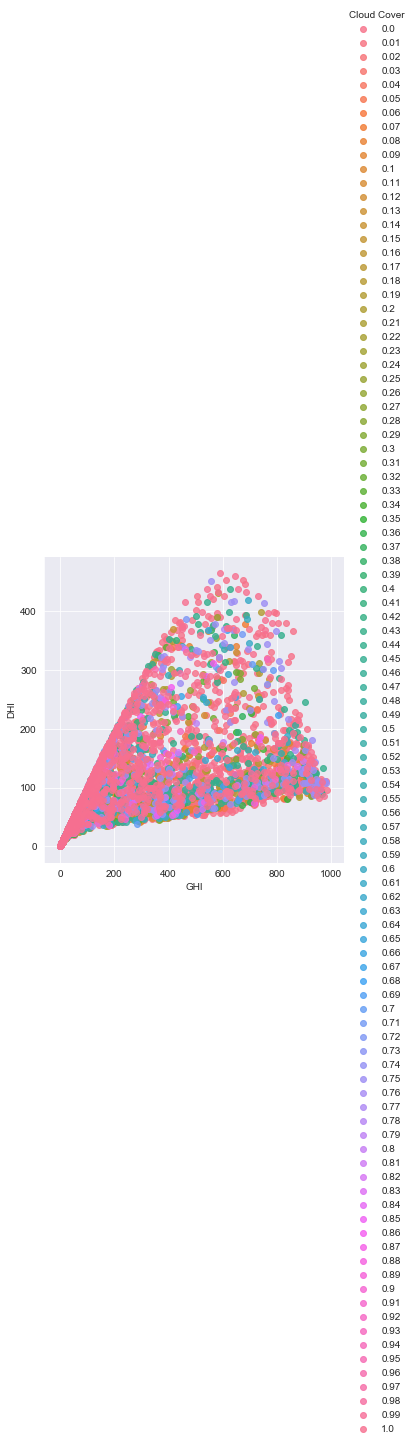

In [16]:
#See the overall data
sns.lmplot('GHI', 'DHI', data=df1_2018, hue='Cloud Cover', fit_reg=False)
plt.show()

## Polynomial fit with log transform of response 

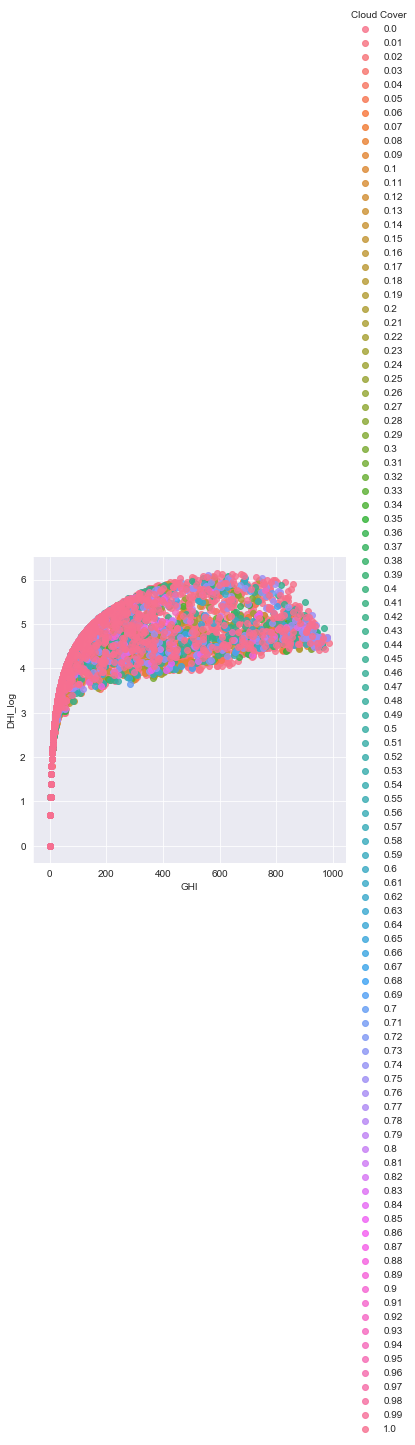

In [17]:
#See the overall data
sns.lmplot('GHI', 'DHI_log', data=df1_2018, hue='Cloud Cover', fit_reg=False)
plt.show()

In [18]:
#Need to fit some poly stuff

#first create X feature vector of [GHI, Cloud Cover]
_GHI = df1_2018['GHI'].values
_Cloud_Cover = df1_2018['Cloud Cover'].values
_X = np.array(list(zip(_GHI, _Cloud_Cover)))

In [19]:
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(_X)
print(len(X_poly))
log_actuals = df1_2018['DHI_log']

4494


In [20]:
clf_poly = linear_model.LinearRegression()
clf_poly.fit(X_poly, log_actuals)
predictions_poly = clf_poly.predict(X_poly)

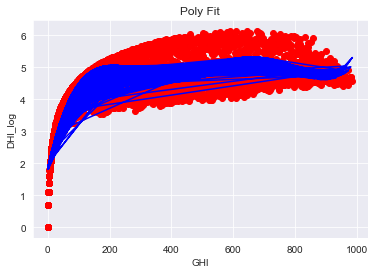

In [21]:
def viz_linear():
    plt.scatter(_GHI, log_actuals, color='red')
    plt.plot(_GHI, predictions_poly, color='blue')
    plt.title('Poly Fit')
    plt.xlabel('GHI')
    plt.ylabel('DHI_log')
    plt.show()
    return
viz_linear()

In [22]:
rmse = np.sqrt(mean_squared_error(log_actuals,predictions_poly))
r2 = r2_score(log_actuals,predictions_poly)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(log_actuals,predictions_poly))
print("mean squared log error is ", mean_squared_log_error(log_actuals, predictions_poly))
print("median absolute error is ", median_absolute_error(log_actuals, predictions_poly))
print("MAPE is ", np.mean(np.abs((log_actuals - predictions_poly) / log_actuals)) * 100)

rmse is  0.4991547780071287
r2 is  0.7568685086844883
mean absolute error is  0.39916258513543906
mean squared log error is  0.016365520068935553
median absolute error is  0.3436932169414999
MAPE is  inf


In [23]:
#LEts see how our residuals hold up, lets see if we can wrangle this data

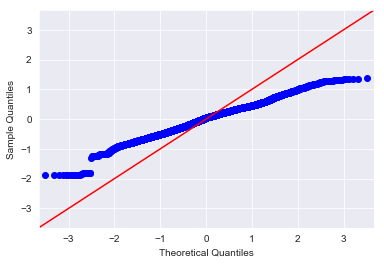

In [24]:
residuals = log_actuals - predictions_poly
sm.qqplot(residuals, line='45')
py.show()

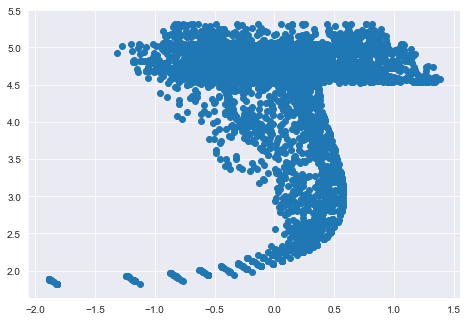

In [25]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(residuals, predictions_poly)
plt.show()

In [26]:
#Residuals are not very normal

In [27]:
"""
For polynomial regression models we assume that:

the behavior of a dependent variable y can be explained by a linear, or curvilinear, additive relationship between the dependent variable and a set of k independent variables (xi, i=1 to k)),
the relationship between the dependent variable y and any independent variable xi is linear or curvilinear (specifically polynomial),
the independent variables xi are independent of each other, and
the errors are independent, normally distributed with mean zero and a constant variance (OLS).
"""

'\nFor polynomial regression models we assume that:\n\nthe behavior of a dependent variable y can be explained by a linear, or curvilinear, additive relationship between the dependent variable and a set of k independent variables (xi, i=1 to k)),\nthe relationship between the dependent variable y and any independent variable xi is linear or curvilinear (specifically polynomial),\nthe independent variables xi are independent of each other, and\nthe errors are independent, normally distributed with mean zero and a constant variance (OLS).\n'

In [28]:
#Problems, problems, problems, we need abetter model!!!

## Log- Log Transform Fitting

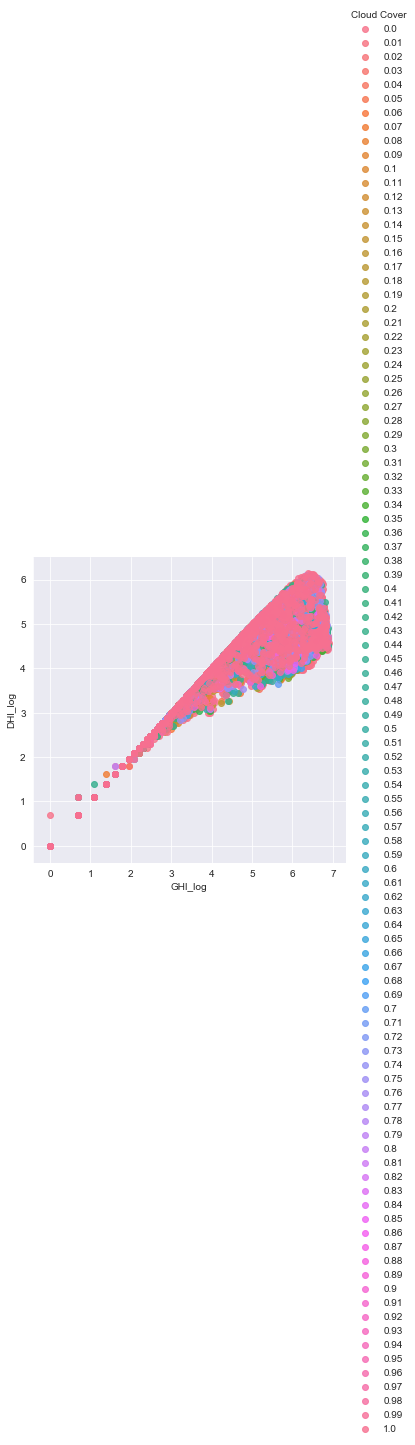

In [29]:
#See the overall data
sns.lmplot('GHI_log', 'DHI_log', data=df1_2018, hue='Cloud Cover', fit_reg=False)
plt.show()

In [30]:
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_GHI_log = df1_2018['GHI_log'].values
_Cloud_Cover = df1_2018['Cloud Cover'].values
_X_log = np.array(list(zip(_GHI_log, _Cloud_Cover)))
log_actuals = df1_2018['DHI_log']

In [31]:
print(_X_log)
print(_X_log.shape)
print(log_actuals.shape)
#Correct shape

[[2.63905733 0.44      ]
 [4.66343909 1.        ]
 [5.61312811 0.75      ]
 ...
 [5.54907608 1.        ]
 [5.0369526  1.        ]
 [3.91202301 0.99      ]]
(4494, 2)
(4494,)


In [32]:
df1_2018_lin_reg = LinearRegression().fit(_X_log, log_actuals)

In [33]:
df1_2018_lin_reg.coef_

array([0.62767233, 0.3428279 ])

In [34]:
df1_2018_lin_reg.intercept_

0.9351297431441159

In [35]:
#r2 Score
df1_2018_lin_reg.score(_X_log, log_actuals)

0.744334589378747

In [36]:
#Predictions and metrics
predictions_log = df1_2018_lin_reg.predict(_X_log)

In [37]:
rmse = np.sqrt(mean_squared_error(log_actuals,predictions_log))
r2 = r2_score(log_actuals,predictions_log)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(log_actuals,predictions_log))
print("mean squared log error is ", mean_squared_log_error(log_actuals, predictions_log))
print("median absolute error is ", median_absolute_error(log_actuals, predictions_log))
print("MAPE is ", np.mean(np.abs((log_actuals - predictions_log) / log_actuals)) * 100)

rmse is  0.5118593177162724
r2 is  0.744334589378747
mean absolute error is  0.4313808973773106
mean squared log error is  0.012859520120319393
median absolute error is  0.41262900659752355
MAPE is  inf


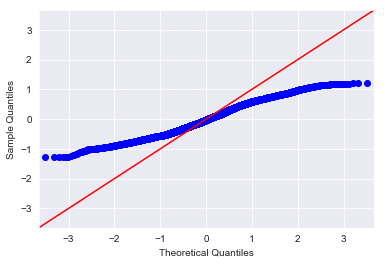

In [38]:
residuals_log = log_actuals - predictions_log
sm.qqplot(residuals_log, line='45')
py.show()

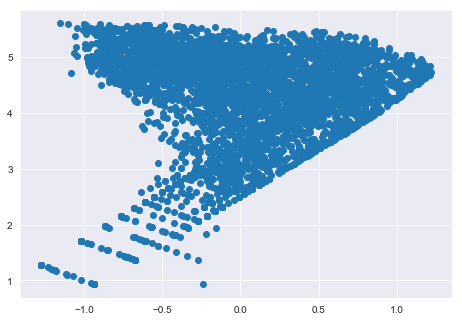

In [39]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(residuals_log, predictions_log)
plt.show()

In [40]:
#Okay none of these are super good. Lets do a boxcox transformation
from sklearn.preprocessing import power_transform

## Power Transform 

In [41]:
box_cox_vector = list(zip(df1_2018['GHI'], df1_2018['Cloud Cover'], df1_2018['DHI']))
box_cox = power_transform(box_cox_vector, method='yeo-johnson')
box_cox_X = list([i[0] for i in box_cox])
box_cox_X2 = list([i[1] for i in box_cox])
box_cox_Y = list([i[2] for i in box_cox])
print(box_cox_X)
print(box_cox_X2)
print(box_cox_Y)
df1_2018['box_cox_X'] = pd.Series(box_cox_X)
df1_2018['box_cox_X2'] = pd.Series(box_cox_X2)
df1_2018['box_cox_Y'] = pd.Series(box_cox_Y)
print(df1_2018)
print(len(df1_2018))

[-1.608115178165106, -0.6564237902200389, 0.1134073322024812, 0.436696321488911, 0.6119679144060186, 0.5670662331074078, 0.35711345700351843, -0.05759381872294776, -0.821629189557112, -1.5267116921769899, -0.3807171628153207, 0.09928921492632571, 0.04146428312098943, -0.25644274314783466, -0.27479874646740815, -0.27018557232957036, -0.47462234558160427, -1.3477575704002918, -1.7046771262199352, -0.9324068668132303, -0.045813654201570304, 0.19217543404444515, 0.2924977424447557, 0.45103592405981174, -0.14710947106332886, -0.4965252139923347, -1.0205482783311957, -1.7321935128422972, -0.7357289170635944, 0.03407695648911768, 0.42223636116654234, 0.4135015153681686, 0.3050017717935124, 0.289356782163511, -0.3266579001526746, -0.8994127983051377, -1.6305628397812642, -0.7153364119890179, -0.4319881453793589, 0.16522697645354634, 0.39589661615965993, 0.3540927908768513, 0.16522697645354634, -0.5416000717969112, -1.1505727253915783, -1.5080888299444428, -0.4584564273937915, 0.130874168101529

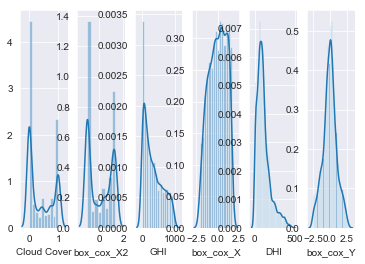

In [42]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=6)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(df1_2018['box_cox_X2'], ax=axs[1])
sns.distplot(df1_2018['GHI'], ax=axs[2])
sns.distplot(df1_2018['box_cox_X'], ax=axs[3])
sns.distplot(df1_2018['DHI'], ax=axs[4])
sns.distplot(df1_2018['box_cox_Y'], ax=axs[5])

In [43]:
#Distributions are much more normal

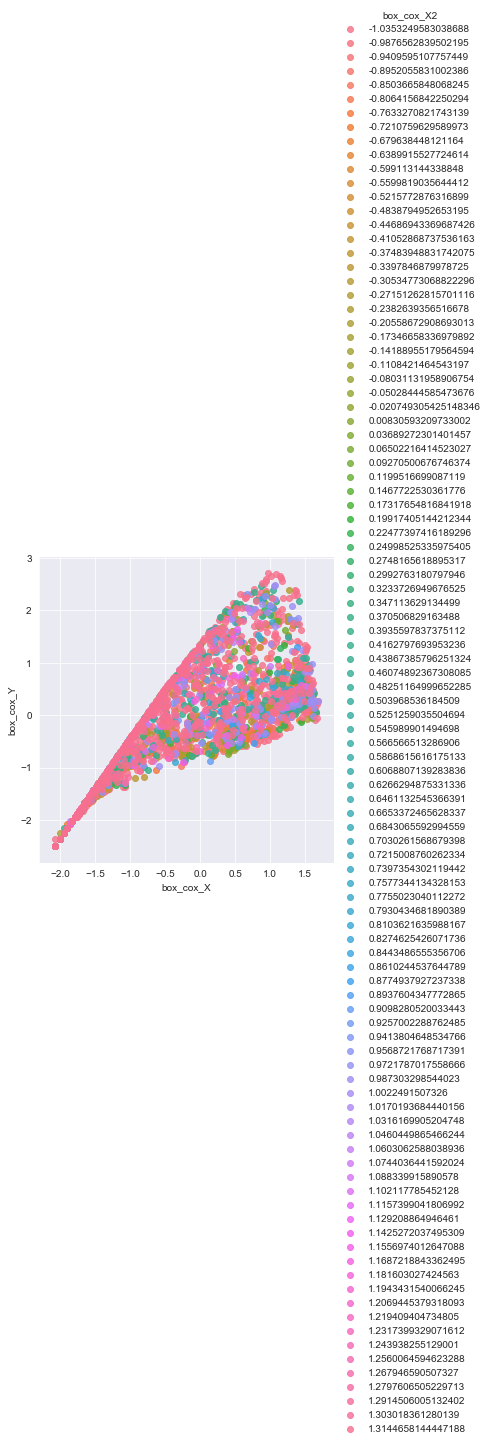

In [44]:
#See the overall data
sns.lmplot('box_cox_X', 'box_cox_Y', data=df1_2018, hue='box_cox_X2', fit_reg=False)
plt.show()

In [45]:
#Still heteroskedastic, whatever, lets fit a curve

In [46]:
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_ptrans_X1 = df1_2018['box_cox_X'].values
_ptrans_X2 = df1_2018['box_cox_X2'].values
_ptrans_X = np.array(list(zip(_ptrans_X1, _ptrans_X2)))
ptrans_actuals = df1_2018['box_cox_Y'].values
print(len(ptrans_actuals))
print(ptrans_actuals[-990])
print(df1_2018['DHI'].values[-990])

4494
nan
215


In [47]:
df2018_yeojohnson_transform = df1_2018.dropna()
print(df2018_yeojohnson_transform)

#Redefine the vars
#Fit the linear model
#first create X feature vector of [GHI, Cloud Cover]
_df2_ptrans_X1 = df2018_yeojohnson_transform['box_cox_X'].values
_df2_ptrans_X2 = df2018_yeojohnson_transform['box_cox_X2'].values
_df2_ptrans_X = np.array(list(zip(_df2_ptrans_X1, _df2_ptrans_X2)))
_df2_ptrans_actuals = df2018_yeojohnson_transform['box_cox_Y'].values

      Year  Month  Day  Hour  Minute  Temperature  Clearsky DHI  Clearsky DNI  \
14    2018      1    1    14      30        -24.4            17           323   
15    2018      1    1    15      30        -22.4            37           762   
16    2018      1    1    16      30        -20.3            48           896   
17    2018      1    1    17      30        -18.5            54           955   
18    2018      1    1    18      30        -17.0            56           976   
...    ...    ...  ...   ...     ...          ...           ...           ...   
4485  2018      7    6    21      30         31.4           133           790   
4486  2018      7    6    22      30         30.9           116           750   
4487  2018      7    6    23      30         30.5            98           675   
4488  2018      7    7     0      30         28.4            71           564   
4489  2018      7    7     1      30         26.5            40           340   

      Clearsky GHI  Cloud T

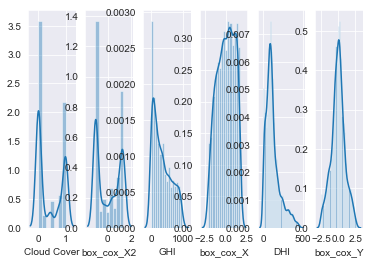

In [48]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=6)
sns.distplot(df2018_yeojohnson_transform['Cloud Cover'], ax=axs[0])
sns.distplot(df2018_yeojohnson_transform['box_cox_X2'], ax=axs[1])
sns.distplot(df2018_yeojohnson_transform['GHI'], ax=axs[2])
sns.distplot(df2018_yeojohnson_transform['box_cox_X'], ax=axs[3])
sns.distplot(df2018_yeojohnson_transform['DHI'], ax=axs[4])
sns.distplot(df2018_yeojohnson_transform['box_cox_Y'], ax=axs[5])

In [49]:
#Data Distribution still much better

In [50]:
df2018_ptransform_lin_reg = LinearRegression().fit(_df2_ptrans_X, _df2_ptrans_actuals)
df2018_ptransform_lin_reg.score(_df2_ptrans_X, _df2_ptrans_actuals)

0.5152314620121814

In [51]:
#BAAAAD score

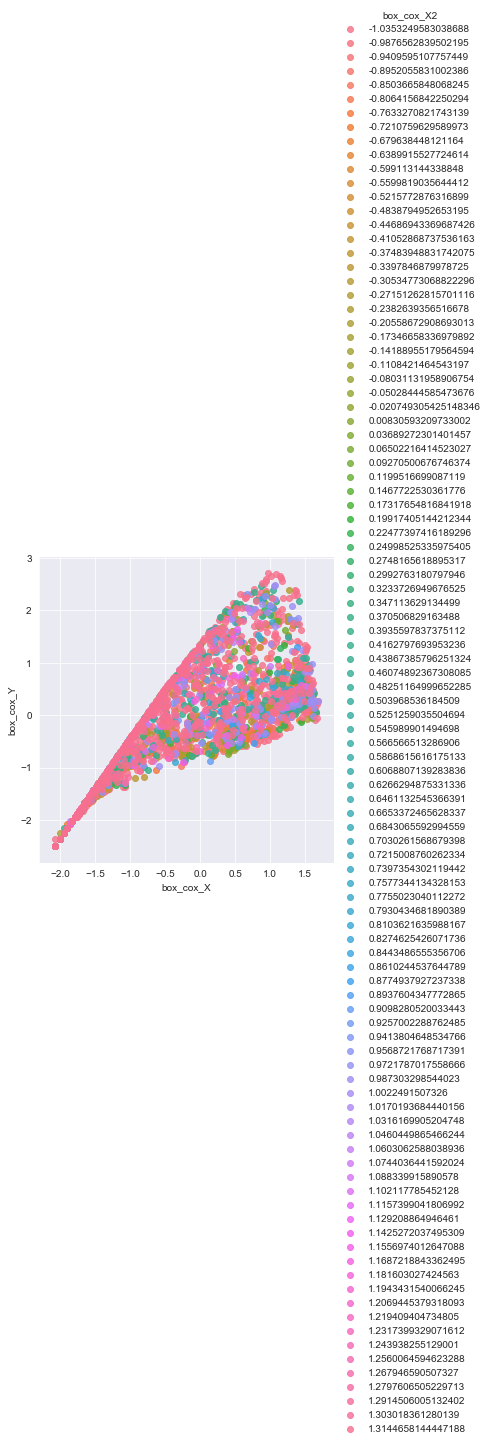

In [52]:
#See the overall data
sns.lmplot('box_cox_X', 'box_cox_Y', data=df2018_yeojohnson_transform, hue='box_cox_X2', fit_reg=False)
plt.show()

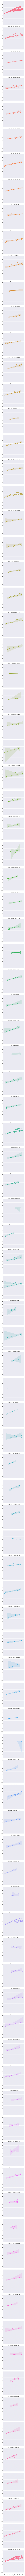

In [53]:
sns.lmplot('box_cox_X', 'box_cox_Y', data=df2018_yeojohnson_transform, hue='box_cox_X2', row='box_cox_X2', fit_reg=True)
plt.show()

In [54]:
#But does not fix heteroskedasticity,
#Possibily because cloud cover data is so skewed

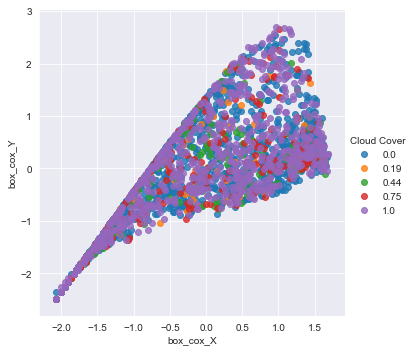

In [55]:
#See the overall data
sns.lmplot('box_cox_X', 'box_cox_Y', data=df2018_yeojohnson_transform, hue='Cloud Cover', fit_reg=False)
plt.show()

## Square root transformation 

In [56]:
#Lets take the square root of everything and see what happens.

In [57]:
ghi_sqrt = np.sqrt(df1_2018['GHI'].values)
dhi_sqrt = np.sqrt(df1_2018['DHI'].values)
cc_sqrt = np.sqrt(df1_2018['Cloud Cover'].values)

df1_2018['ghi_sqrt'] = pd.Series(ghi_sqrt)
df1_2018['dhi_sqrt'] = pd.Series(dhi_sqrt)
df1_2018['cc_sqrt'] = pd.Series(cc_sqrt)

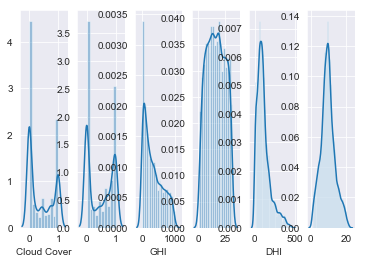

In [58]:
#Take a look at data distribution
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=6)
sns.distplot(df1_2018['Cloud Cover'], ax=axs[0])
sns.distplot(cc_sqrt, ax=axs[1])
sns.distplot(df1_2018['GHI'], ax=axs[2])
sns.distplot(ghi_sqrt, ax=axs[3])
sns.distplot(df1_2018['DHI'], ax=axs[4])
sns.distplot(dhi_sqrt, ax=axs[5])

In [59]:
#Data is much more normal

In [60]:
#Lets fit an OLS
_X_sqrt = list(zip(ghi_sqrt, cc_sqrt))
df2018_sqrt_fit = LinearRegression().fit(_X_sqrt, dhi_sqrt)
df2018_sqrt_fit.score(_X_sqrt, dhi_sqrt)

0.44908614077505316

In [61]:
#oooooohhhh that's not good
show_model_metrics(_X_sqrt, dhi_sqrt, df2018_sqrt_fit)

rmse is  2.9217933487276126
r2 is  0.44908614077505316
mean absolute error is  2.361639657906579
mean squared log error is  0.082158762510106
median absolute error is  2.0717014056599004
MAPE is  30.678643885731518


(array([ 5.90201353,  8.49488043, 10.33528859, ..., 10.35309519,
         9.17978769,  7.44319726]),
 array([-2.43791192, -1.21477054, -2.5893219 , ..., -0.91911406,
        -0.87316383, -1.69863461]))

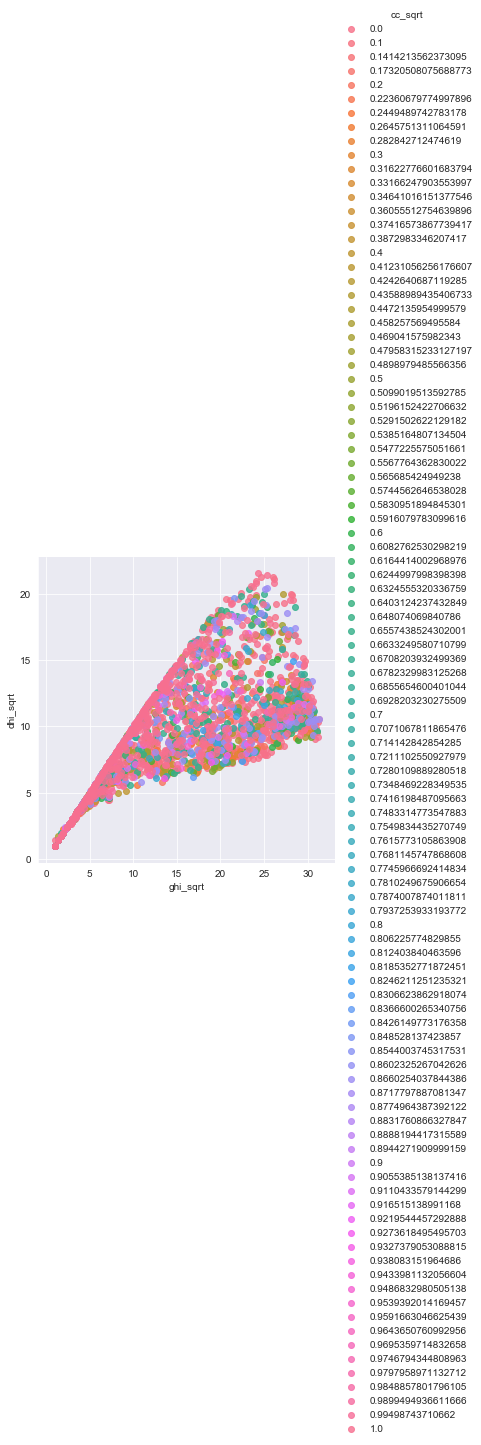

In [62]:
meta_visualization(df1_2018, x='ghi_sqrt', y='dhi_sqrt', z='cc_sqrt')

## Logit Transformation 

In [63]:
from scipy.special import logit

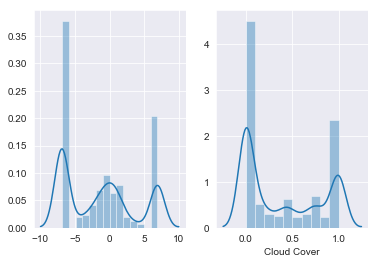

In [64]:
logit_vals = (df1_2018['Cloud Cover'].values)

for i in range(len(logit_vals)):
    if logit_vals[i] ==0:
        logit_vals[i]+=0.001
    elif logit_vals[i]==1:
        logit_vals[i]-=0.001
logit_vals = logit(logit_vals)


sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=2)
sns.distplot(logit_vals, ax=axs[0])
sns.distplot(df1_2018['Cloud Cover'], ax=axs[1])


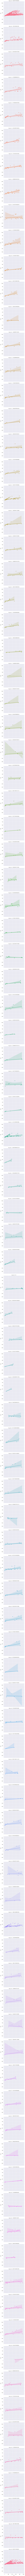

In [65]:
#Data is a bit smoother....but still peaked
df1_2018['logt_vals'] = pd.Series(logit_vals)

sns.lmplot('GHI', 'DHI', data=df1_2018, hue='logt_vals', row='logt_vals', fit_reg=True)
plt.show()

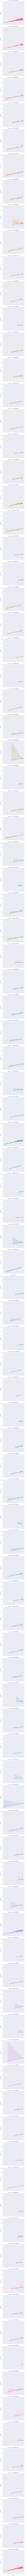

In [66]:
df1_2018['logt_vals'] = pd.Series(logit_vals)

sns.lmplot('GHI_log', 'DHI_log', data=df1_2018, hue='logt_vals', row='logt_vals', fit_reg=True)
plt.show()

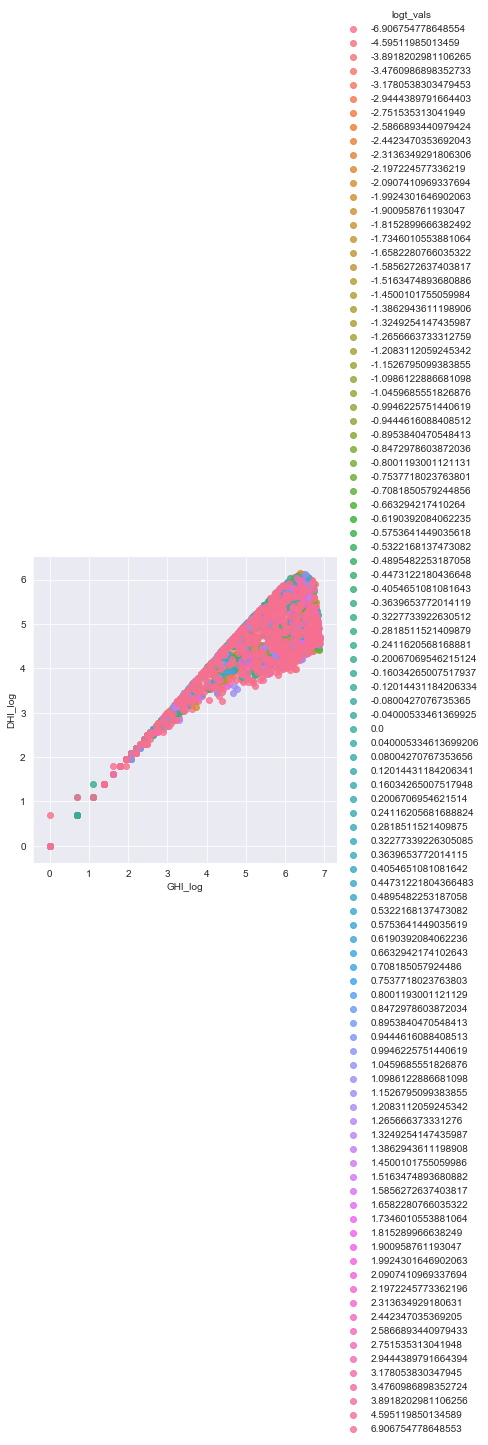

In [67]:
meta_visualization(df1_2018, x='GHI_log', y='DHI_log', z='logt_vals')

In [68]:
_X_logit = np.array(list(zip(_GHI_log, logit_vals)))
df2018_logit_regression = LinearRegression().fit(_X_logit, log_actuals)
df2018_logit_regression.score(_X_logit, log_actuals)

0.7423416730220415

In [69]:
#Not bad, lets make some predictions
preds_logit_log = df2018_logit_regression.predict(_X_logit)

In [70]:
rmse = np.sqrt(mean_squared_error(log_actuals,preds_logit_log))
r2 = r2_score(log_actuals,preds_logit_log)
print("rmse is ", rmse)
print("r2 is ",r2)
print("mean absolute error is ",mean_absolute_error(log_actuals,preds_logit_log))
print("mean squared log error is ", mean_squared_log_error(log_actuals, preds_logit_log))
print("median absolute error is ", median_absolute_error(log_actuals, preds_logit_log))
print("MAPE is ", np.mean(np.abs((log_actuals - preds_logit_log) / log_actuals)) * 100)

rmse is  0.5138504212530477
r2 is  0.7423416730220415
mean absolute error is  0.4333386346193195
mean squared log error is  0.012946941106587666
median absolute error is  0.41296677408060134
MAPE is  inf


In [71]:
df1_2018_lin_reg.score(_X_log, log_actuals)

0.744334589378747

In [72]:
#Similair to log log transformation

In [73]:
#Lets try with box cox
_X_logit_2 = np.array(list(zip(box_cox_X, logit_vals)))
df2018_logit_regression2 = LinearRegression().fit(_X_logit_2, box_cox_Y)
df2018_logit_regression2.score(_X_logit_2, box_cox_Y)

0.5150425478934472

In [74]:
#no good. 

In [75]:
"""SUMMARY SO FAR
1.Best Models
    1. Polynomial fit on log transformed response 
        r2 is  0.7568685086844883
        mean absolute error is  0.39916258513543906
    2. OLS on log log transformed
        r2 is  0.744334589378747
        mean absolute error is  0.4313808973773106
    3. OLS on logit transformed cloud cover with log transformed feature and response
        r2 is 0.7423416730220415
        mean absolute error is  0.4333386346193195
    4. OLS power transformed for all variables
        r2 is 0.5152314620121814
    5. OLS on power transformation features and response with logit transformed cloud cover
        r2 is 0.5150425478934472
        
"""

'SUMMARY SO FAR\n1.Best Models\n    1. Polynomial fit on log transformed response \n        r2 is  0.7568685086844883\n        mean absolute error is  0.39916258513543906\n    2. OLS on log log transformed\n        r2 is  0.744334589378747\n        mean absolute error is  0.4313808973773106\n    3. OLS on logit transformed cloud cover with log transformed feature and response\n        r2 is 0.7423416730220415\n        mean absolute error is  0.4333386346193195\n    4. OLS power transformed for all variables\n        r2 is 0.5152314620121814\n    5. OLS on power transformation features and response with logit transformed cloud cover\n        r2 is 0.5150425478934472\n        \n'

In [76]:
#Let's go a complete new direction. Let's try generalized least squares
#since variance in Y for each X is different linear estimaters like OLS wont work
#The big issue is the distribution of residuals

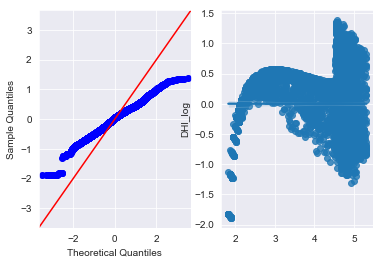

In [77]:
#Poly regression residuals
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=2)
residuals = log_actuals - predictions_poly
sm.qqplot(residuals, line='45', ax=axs[0])

sns.regplot(x=predictions_poly, y=residuals, ax=axs[1], label="Residual vs fitted")


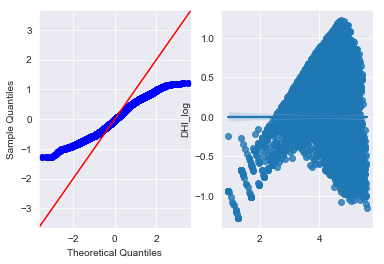

In [78]:
#Log Log OLS regression residuals
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=2)
residuals = log_actuals - predictions_log
sm.qqplot(residuals, line='45', ax=axs[0])

sns.regplot(x=predictions_log, y=residuals, ax=axs[1], label="Residual vs fitted")


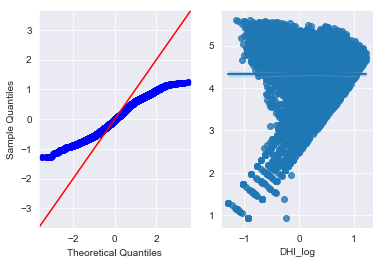

In [79]:
#Log-Logit OLS resgression
#Poly regression residuals
sns.set_style('darkgrid')
fig, axs = plt.subplots(ncols=2)
residuals = log_actuals - preds_logit_log
sm.qqplot(residuals, line='45', ax=axs[0])

sns.regplot(x=residuals, y=preds_logit_log, ax=axs[1], label="Residual vs fitted")


In [80]:
#GLS minimizes distance to residuals relative to covariance of those residuals


## Generalized Least Squares Regression

In [81]:
#Use stats models on original data

exog = list(zip(df1_2018['GHI'].values, df1_2018['Cloud Cover'].values))
endog = df1_2018['DHI'].values
data_exog = sm.add_constant(exog)
ols_resid = sm.OLS(endog, exog).fit().resid

res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params

In [82]:
"""rho is a consistent estimator of the correlation of the
residuals from an OLS fit of the data. 
It is assumed that this is the true rho of the AR process data.
"""

'rho is a consistent estimator of the correlation of the\nresiduals from an OLS fit of the data. \nIt is assumed that this is the true rho of the AR process data.\n'

In [83]:
# from scipy.linalg import toeplitz
# order = toeplitz(np.arange(len(df1_2018)))
# sigma = rho**order

In [84]:
#sigma is an n x n matrix of the autocorrelation structure of the data.

In [85]:
gls_model = sm.GLS(endog, exog)
gls_results = gls_model.fit()
print(gls_results.summary())

                                 GLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.689
Model:                            GLS   Adj. R-squared (uncentered):              0.689
Method:                 Least Squares   F-statistic:                              4981.
Date:                Mon, 30 Mar 2020   Prob (F-statistic):                        0.00
Time:                        11:35:32   Log-Likelihood:                         -25872.
No. Observations:                4494   AIC:                                  5.175e+04
Df Residuals:                    4492   BIC:                                  5.176e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [86]:
preds_gls = gls_results.predict()

In [87]:
residuals_gls = endog - preds_gls

In [88]:
print("mean absolute error is ",mean_absolute_error(endog,preds_gls))
print("mean squared log error is ", mean_squared_log_error(endog, preds_gls))
print("median absolute error is ", median_absolute_error(endog, preds_gls))
# print("MAPE is ", np.mean(np.abs((endog - preds_gls) / endog)) * 100)

mean absolute error is  55.71666009395057
mean squared log error is  0.6391686930905663
median absolute error is  40.39015618850047


## GLS in Log-Log Model

In [89]:
#Use stats models on original data

exog = list(zip(df1_2018['GHI_log'].values, df1_2018['Cloud Cover'].values))
endog = df1_2018['DHI_log'].values
data_exog = sm.add_constant(exog)
ols_resid = sm.OLS(endog, exog).fit().resid

res_fit = sm.OLS(ols_resid[1:], ols_resid[:-1]).fit()
rho = res_fit.params

In [90]:
gls_model = sm.GLS(endog, exog)
gls_results = gls_model.fit()
print(gls_results.summary())

                                 GLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.984
Model:                            GLS   Adj. R-squared (uncentered):              0.984
Method:                 Least Squares   F-statistic:                          1.391e+05
Date:                Mon, 30 Mar 2020   Prob (F-statistic):                        0.00
Time:                        11:35:32   Log-Likelihood:                         -3770.3
No. Observations:                4494   AIC:                                      7545.
Df Residuals:                    4492   BIC:                                      7557.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [91]:
preds_gls = gls_results.predict()
residuals_gls = endog - preds_gls

In [92]:
print("mean absolute error is ",mean_absolute_error(endog,preds_gls))
print("mean squared log error is ", mean_squared_log_error(endog, preds_gls))
print("median absolute error is ", median_absolute_error(endog, preds_gls))
# print("MAPE is ", np.mean(np.abs((endog - preds_gls) / endog)) * 100)

mean absolute error is  0.47652160632172497
mean squared log error is  0.011371151925362992
median absolute error is  0.4512538875240555


In [93]:
print(gls_model.sigma)

None


In [94]:
#array([0.62767233, 0.3428279 ])